#sam, vitmatte 따로

In [ ]:
#install detectron 2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5amfh_a1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5amfh_a1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 864913f0e57e87a75c8cc0c7d79ecbd774fc669b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6119678 sha256=8dc6cd0398e15e60686ef55327d1b

In [ ]:
#install segment-anything
%cd /content/
!pip install git+https://github.com/facebookresearch/segment-anything.git

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wvpx8_7y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wvpx8_7y
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=b20a6619ead06d66efb94c7db2b54719e34cb8de616913b6988f4ede978297d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ux29y6bo/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
#install vitmatte
import os
os.chdir('/content/')
!git clone https://github.com/hustvl/ViTMatte.git

Cloning into 'ViTMatte'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 162 (delta 42), reused 40 (delta 38), pack-reused 107
Receiving objects: 100% (162/162), 3.96 MiB | 9.63 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [ ]:
import os
import cv2
import torch
import numpy as np
#import gradio as gr
from PIL import Image
from torchvision.ops import box_convert
import sys
import os


#from detectron2.config import LazyConfig, instantiate
from detectron2.config.lazy import LazyConfig
from detectron2.config.instantiate import instantiate
from detectron2.checkpoint import DetectionCheckpointer
from segment_anything import sam_model_registry, SamPredictor


models = {
	'vit_h': '/content/drive/MyDrive/Matting-Anything/pretrained/sam_vit_h_4b8939.pth'
    #'vit_b': './pretrained/sam_vit_b_01ec64.pth'
}

vitmatte_models = {
	'vit_b': '/content/drive/MyDrive/Matting-Anything/pretrained/ViTMatte_B_DIS.pth',
}

vitmatte_config = {
	'vit_b': '/content/drive/MyDrive/Matte-Anything/configs/matte_anything.py',
}

grounding_dino = {
    'config': '/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py',
    'weight': '/content/drive/MyDrive/Matting-Anything/pretrained/groundingdino_swint_ogc.pth'
}

#import groundingdino.datasets.transforms as T
#from groundingdino.util.inference import load_model as dino_load_model, predict as dino_predict, annotate as dino_annotate

def generate_checkerboard_image(height, width, num_squares):
    num_squares_h = num_squares
    square_size_h = height // num_squares_h
    square_size_w = square_size_h
    num_squares_w = width // square_size_w


    new_height = num_squares_h * square_size_h
    new_width = num_squares_w * square_size_w
    image = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(num_squares_h):
        for j in range(num_squares_w):
            start_x = j * square_size_w
            start_y = i * square_size_h
            color = 255 if (i + j) % 2 == 0 else 200
            image[start_y:start_y + square_size_h, start_x:start_x + square_size_w] = color

    image = cv2.resize(image, (width, height))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return image


def init_segment_anything(model_type):
    """
    Initialize the segmenting anything with model_type in ['vit_b', 'vit_l', 'vit_h']
    """

    current_directory = os.getcwd()
    print("현재 경로:", current_directory)
    new_directory = "/content/drive/MyDrive/Matte-Anything"
    os.chdir(new_directory)
    print("변경된 경로:",os.getcwd())
    sam = sam_model_registry[model_type](checkpoint=models[model_type]).to(device)  #여기서 런타임 종료됨...
    predictor = SamPredictor(sam)

    return predictor

def generate_trimap(mask, erode_kernel_size=10, dilate_kernel_size=10):
    erode_kernel = np.ones((erode_kernel_size, erode_kernel_size), np.uint8)
    dilate_kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
    eroded = cv2.erode(mask, erode_kernel, iterations=5)
    dilated = cv2.dilate(mask, dilate_kernel, iterations=5)
    trimap = np.zeros_like(mask)
    trimap[dilated==255] = 128
    trimap[eroded==255] = 255
    return trimap

# user click the image to get points, and show the points on the image
# def get_point(img, sel_pix, point_type, evt: gr.SelectData):
#     if point_type == 'foreground_point':
#         sel_pix.append((evt.index, 1))   # append the foreground_point
#     elif point_type == 'background_point':
#         sel_pix.append((evt.index, 0))    # append the background_point
#     else:
#         sel_pix.append((evt.index, 1))    # default foreground_point
#     # draw points
#     for point, label in sel_pix:
#         cv2.drawMarker(img, point, colors[label], markerType=markers[label], markerSize=20, thickness=5)
#     if img[..., 0][0, 0] == img[..., 2][0, 0]:  # BGR to RGB
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     return img if isinstance(img, np.ndarray) else np.array(img)

def get_point(img, sel_pix, point_type, index): #evt 지워도 되나...
    if point_type == 'foreground_point':
        sel_pix.append((index, 1))   # append the foreground_point
    elif point_type == 'background_point':
        sel_pix.append((index, 0))    # append the background_point
    else:
        sel_pix.append((index, 1))    # default foreground_point
    # draw points
    for point, label in sel_pix:
        cv2.drawMarker(img, point, colors[label], markerType=markers[label], markerSize=20, thickness=5)
    if img[..., 0][0, 0] == img[..., 2][0, 0]:  # BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img if isinstance(img, np.ndarray) else np.array(img)


# undo the selected point
def undo_points(orig_img, sel_pix):
    temp = orig_img.copy()
    # draw points
    if len(sel_pix) != 0:
        sel_pix.pop()
        for point, label in sel_pix:
            cv2.drawMarker(temp, point, colors[label], markerType=markers[label], markerSize=20, thickness=5)
    if temp[..., 0][0, 0] == temp[..., 2][0, 0]:  # BGR to RGB
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    return temp if isinstance(temp, np.ndarray) else np.array(temp)

# undo all selected points
def undo_all_points(orig_img, sel_pix):
    if orig_img is None:
        print("Please upload pictures first!")
    else:
        temp = orig_img.copy()
        while len(sel_pix) != 0:
            sel_pix.pop()
        if temp[..., 0][0, 0] == temp[..., 2][0, 0]:  # BGR to RGB
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    return temp if isinstance(temp, np.ndarray) else np.array(temp)

# clear the fg_caption
def clear_fg_caption(fg_caption):
    fg_caption = ""
    return fg_caption

# once user upload an image, the original image is stored in `original_image`
def store_img(img):
    return img, []  # when new image is uploaded, `selected_points` should be empty

def convert_pixels(gray_image, boxes):
    converted_image = np.copy(gray_image)

    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        converted_image[y1:y2, x1:x2][converted_image[y1:y2, x1:x2] == 1] = 0.5

    return converted_image



if __name__ == "__main__":
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    sam_model = 'vit_h'
    vitmatte_model = 'vit_b'

    colors = [(255, 0, 0), (0, 255, 0)]
    markers = [1, 5] #marker type

    print('Initializing models... Please wait...')

    predictor = init_segment_anything(sam_model)
    #vitmatte = init_vitmatte(vitmatte_model)
    #grounding_dino =  dino_load_model(grounding_dino['config'], grounding_dino['weight'])#dino_load_model(grounding_dino['config'], grounding_dino['weight'])



    def run_sam(input_x, selected_points, fg_box_threshold, fg_text_threshold, fg_caption):

        predictor.set_image(input_x)

        if len(selected_points) != 0:
            points = torch.Tensor([p for p, _ in selected_points]).to(device).unsqueeze(1)
            labels = torch.Tensor([int(l) for _, l in selected_points]).to(device).unsqueeze(1)
            transformed_points = predictor.transform.apply_coords_torch(points, input_x.shape[:2])
            print(points.size(), transformed_points.size(), labels.size(), input_x.shape, points)
            point_coords=transformed_points.permute(1, 0, 2)
            point_labels=labels.permute(1, 0)
        else:
            transformed_points, labels = None, None
            point_coords, point_labels = None, None

        transformed_boxes = None

        # predict segmentation according to the boxes
        masks, scores, logits = predictor.predict_torch(
            point_coords = point_coords,
            point_labels = point_labels,
            boxes = transformed_boxes,
            multimask_output = False,
        )
        masks = masks.cpu().detach().numpy()
        mask_all = np.ones((input_x.shape[0], input_x.shape[1], 3))
        for ann in masks:
            color_mask = np.random.random((1, 3)).tolist()[0]
            for i in range(3):
                mask_all[ann[0] == True, i] = color_mask[i]
        img = input_x / 255 * 0.3 + mask_all * 0.7


        return masks

Initializing models... Please wait...
현재 경로: /content
변경된 경로: /content/drive/MyDrive/Matte-Anything


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#vitmatte function




# download codes and pre-trained weights

#!pip install gdown
#import gdown
#url='https://drive.google.com/u/0/uc?id=12VKhSwE_miF9lWQQCgK7mv83rJIls3Xe'
#file_name='ViTMatte_S_Com.pth'
#gdown.download(url, file_name) #google drive에 있는 파일 다운받기...

!pip install fairscale
!pip install timm
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

import os
import cv2
import torch
import numpy as np
#import gradio as gr
from PIL import Image
import torch
from torchvision.ops import box_convert
import sys


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairscale: filename=fairscale-0.4.13-py3-none-any.whl size=332104 sha256=467fb9398040735a7046228ba2a6d3af7b62c6fb38c57254210888bdf4ea80d4
  Stored in directory: /root/.cache/pip/wheels/78/a4/c0/fb0a7ef03cff161611c3fa40c6cf898f76e58ec421b88e8cb3
Successfully built fairscale
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.0 MB/s eta 0:00:00


In [ ]:
#from typing import Optional, Tuple

def generate_checkerboard_image(height, width, num_squares):
    num_squares_h = num_squares
    square_size_h = height // num_squares_h
    square_size_w = square_size_h
    num_squares_w = width // square_size_w


    new_height = num_squares_h * square_size_h
    new_width = num_squares_w * square_size_w
    image = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(num_squares_h):
        for j in range(num_squares_w):
            start_x = j * square_size_w
            start_y = i * square_size_h
            color = 255 if (i + j) % 2 == 0 else 200
            image[start_y:start_y + square_size_h, start_x:start_x + square_size_w] = color

    image = cv2.resize(image, (width, height))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return image


def generate_trimap(mask, erode_kernel_size=10, dilate_kernel_size=10):
    erode_kernel = np.ones((erode_kernel_size, erode_kernel_size), np.uint8)
    dilate_kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
    eroded = cv2.erode(mask, erode_kernel, iterations=5)
    dilated = cv2.dilate(mask, dilate_kernel, iterations=5)
    trimap = np.zeros_like(mask)
    trimap[dilated==255] = 128
    trimap[eroded==255] = 255
    return trimap

def store_img(img):
    return img, []  # when new image is uploaded, `selected_points` should be empty

def convert_pixels(gray_image, boxes):
    converted_image = np.copy(gray_image)

    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        converted_image[y1:y2, x1:x2][converted_image[y1:y2, x1:x2] == 1] = 0.5

    return converted_image

def covert_tracer_output_to_vitmatte_input(mask_path): #image path: '~~/~~/~~.png'
    # Load your background-removed image
    image = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    # Assuming the alpha channel (if present) represents transparency (0 = removed, 255 = retained)
    if image.shape[2] == 4:  # Check if the image has an alpha channel
        alpha_channel = image[:, :, 3]
        mask = (alpha_channel == 0)  # Create a mask where removed part is True

        # Invert the mask if necessary (to have True for removed part and False for foreground)
        mask = ~mask

        # Convert the mask to a 1024x1024 list
        mask_list = mask.tolist()  # Convert the NumPy array to a list
        # Now mask_list contains the True/False values for removed/background parts

        return mask_list

def covert_tracer_output_to_vitmatte_input2(mask_image): #image path: '~~/~~/~~.png'
    # Load your background-removed image
    #image = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    # Assuming the alpha channel (if present) represents transparency (0 = removed, 255 = retained)
    if mask_image.shape[2] == 4:  # Check if the image has an alpha channel
        alpha_channel = mask_image[:, :, 3]
        mask = (alpha_channel == 0)  # Create a mask where removed part is True

        # Invert the mask if necessary (to have True for removed part and False for foreground)
        mask = ~mask

        return mask

import numpy as np
import torch
from PIL import Image
import torchvision.transforms.functional as F


#def cal_foreground(image_dir, alpha_dir):
def cal_foreground(image_dir, alpha):
    """
    Calculate the foreground of the image.
    Input:
        image_dir: the directory of the image
        alpha_dir: the directory of the alpha matte
    Output:
        foreground: the foreground of the image, numpy array
    """
    image = Image.open(image_dir).convert('RGB')
    #alpha = Image.open(alpha_dir).convert('L')
    alpha = alpha.convert('L')
    alpha = F.to_tensor(alpha).unsqueeze(0)
    image = F.to_tensor(image).unsqueeze(0)
    foreground = image * alpha + (1 - alpha)
    foreground = foreground.squeeze(0).permute(1, 2, 0).numpy()

    return foreground


def cal_foreground2(image, alpha_np):
    """
    Calculate the foreground of the image with transparent background.
    Input:
        image_dir: the directory of the image
        alpha: the alpha mask as a PIL Image (1024, 1024)
    Output:
        foreground: the foreground of the image, PIL Image
    """
    #image = Image.open(image_dir).convert('RGBA')

    # Create a new blank RGBA image with the same size as the original image
    foreground = Image.new('RGBA', image.size)

    # Set alpha values based on the provided alpha mask
    for y in range(image.size[1]):
        for x in range(image.size[0]):
            r, g, b, a_original = image.getpixel((x, y))  # Get RGBA values from the original image

            # Multiply alpha channel with the provided alpha mask
            a = int(a_original * alpha_np[y, x] / 255)  # Scale alpha values to [0, 255]

            # Set the RGBA values for each pixel in the new image
            foreground.putpixel((x, y), (r, g, b, a))

    return foreground


# common functions

import os
from PIL import Image
from os.path import join as opj
from torchvision.transforms import functional as F
from detectron2.engine import default_argument_parser
from detectron2.config import LazyConfig, instantiate
from detectron2.checkpoint import DetectionCheckpointer
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def infer_one_image(model, input, save_dir=None):
    """
    Infer the alpha matte of one image.
    Input:
        model: the trained model
        image: the input image
        trimap: the input trimap
    """
    output = model(input)['phas'].flatten(0, 2)
    output = F.to_pil_image(output) #tensor to pil

    #output.save(opj(save_dir))
    #output.save(save_dir)


    #return None
    return output

def init_model(model, checkpoint, device):
    """
    Initialize the model.
    Input:
        config: the config file of the model
        checkpoint: the checkpoint of the model
    """
    assert model in ['vitmatte-s', 'vitmatte-b']
    if model == 'vitmatte-s':
        config = '/content/ViTMatte/configs/common/model.py'
        cfg = LazyConfig.load(config)
        model = instantiate(cfg.model)
        model.to(device)
        model.eval()
        DetectionCheckpointer(model).load(checkpoint)
    elif model == 'vitmatte-b':
        config = '/content/ViTMatte/configs/common/model.py'
        cfg = LazyConfig.load(config)
        cfg.model.backbone.embed_dim = 768
        cfg.model.backbone.num_heads = 12
        cfg.model.decoder.in_chans = 768
        model = instantiate(cfg.model)
        model.to(device)
        model.eval()
        DetectionCheckpointer(model).load(checkpoint)
    return model


#def get_data(image_dir, trimap_dir):
def get_data(image, trimap):
    """
    Get the data of one image.
    Input:
        image_dir: the directory of the image
        trimap_dir: the directory of the trimap
    """
    #image = Image.open(image_dir).convert('RGB')
    image = Image.fromarray(image).convert('RGB')
    image = F.to_tensor(image).unsqueeze(0)
    #trimap = Image.open(trimap_dir).convert('L')
    trimap = Image.fromarray(trimap).convert('L')
    trimap = F.to_tensor(trimap).unsqueeze(0)

    return {
        'image': image,
        'trimap': trimap
    }





def merge_new_bg(image_dir, bg_dir, alpha_dir):
    """
    Merge the alpha matte with a new background.
    Input:
        image_dir: the directory of the image
        bg_dir: the directory of the new background
        alpha_dir: the directory of the alpha matte
    """
    image = Image.open(image_dir).convert('RGB')
    bg = Image.open(bg_dir).convert('RGB')
    alpha = Image.open(alpha_dir).convert('L')
    image = F.to_tensor(image)
    bg = F.to_tensor(bg)
    bg = F.resize(bg, image.shape[-2:])
    alpha = F.to_tensor(alpha)
    new_image = image * alpha + bg * (1 - alpha)

    new_image = new_image.squeeze(0).permute(1, 2, 0).numpy()
    return new_image


In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

#vitmatte_model = 'vit_b'
vitmatte_model = init_model(model='vitmatte-b', checkpoint='/content/drive/MyDrive/Matte-Anything/pretrained/ViTMatte_B_DIS.pth', device=device)

 #   def run_vitmatte(vitmatte_input, selected_points, erode_kernel_size, dilate_kernel_size, fg_box_threshold, fg_text_threshold, fg_caption, tr_box_threshold, tr_text_threshold, tr_caption = "glass, lens, crystal, diamond, bubble, bulb, web, grid"):
def run_vitmatte(model, input_x, masks, erode_kernel_size, dilate_kernel_size, fg_box_threshold, fg_text_threshold, fg_caption, tr_box_threshold, tr_text_threshold, tr_caption = "glass, lens, crystal, diamond, bubble, bulb, web, grid"):
    #set_image(input_x, "RGB")

    # generate alpha matte
    torch.cuda.empty_cache()
    mask = masks.astype(np.uint8)*255
    trimap = generate_trimap(mask, erode_kernel_size, dilate_kernel_size).astype(np.float32)

    #input = get_data(input_x, trimap_dir) #save_dir = where to save alpha(mask)
    input = get_data(input_x, trimap)

    torch.cuda.empty_cache()

    alpha = infer_one_image(model, input) #alpha: PIL Image

    # Convert alpha to a numpy array
    alpha_np = alpha.convert('L')  # Convert to grayscale
    alpha_np = np.array(alpha_np)  # Convert to numpy array

    fg2 = cal_foreground2(Image.fromarray(input_x), alpha_np) #vitmatte 결과이지만 배경이 흰색이 아닌 투명

    return fg2


#돌리기

In [ ]:
#run grounded sam
input_url = "/content/drive/MyDrive/스모어톡/프리렌서/배경제거/background_removal_test/input_nukki/a cartoon character holding a spoon with a scoop of ice cream in it(3).png"

input_x = cv2.imread(input_url)

# Convert BGR to RGB (if needed) and get the image array
input_x = cv2.cvtColor(input_x, cv2.COLOR_BGR2RGB)

#selected_points = [((x1, y1), 1), ((x2, y2), 1), ...((xn, yn), 1)] #label 1 = foreground
selected_points=[((550,400),1),((530,150),1),((530,250),1),((200,470),1),((530,450),1),((830,600),1),((530,650),1),((530,750),1),((400,900),1),((650,900),1)]

fg_box_threshold=0.5
fg_text_threshold=0.5
#fg_caption="a cake in the middle"
fg_caption=""


masks = run_sam(input_x, selected_points, fg_box_threshold, fg_text_threshold, fg_caption)  #masks : numpy 형태

torch.Size([10, 1, 2]) torch.Size([10, 1, 2]) torch.Size([10, 1]) (1024, 1024, 3) tensor([[[550., 400.]],

        [[530., 150.]],

        [[530., 250.]],

        [[200., 470.]],

        [[530., 450.]],

        [[830., 600.]],

        [[530., 650.]],

        [[530., 750.]],

        [[400., 900.]],

        [[650., 900.]]], device='cuda:0')


In [ ]:
#run_vitmatte
import os
import matplotlib.image as mpimg

erode_kernel_size =10
dilate_kernel_size=10
tr_box_threshold=0.5
tr_text_threshold=0.5
tr_caption= "glass, lens, crystal, diamond, bubble, bulb, web, grid"  #transparent 할것 같은 예시들



# Construct the full paths for input image and mask
#input_path = os.path.join(input_dir, input_file)
img2 = Image.open(input_url).convert('RGBA') # read image
input_image = np.array(img2) #원래 받는건 RGBA일수도....여기서는 위처럼 RGB로 받아야하나?



foreground_alpha2 = run_vitmatte(vitmatte_model,input_image, masks[0][0], erode_kernel_size, dilate_kernel_size, fg_box_threshold, fg_text_threshold, fg_caption, tr_box_threshold, tr_text_threshold, tr_caption)


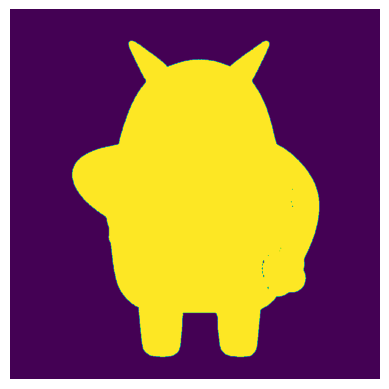

In [ ]:
plt.imshow(masks[0][0])
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

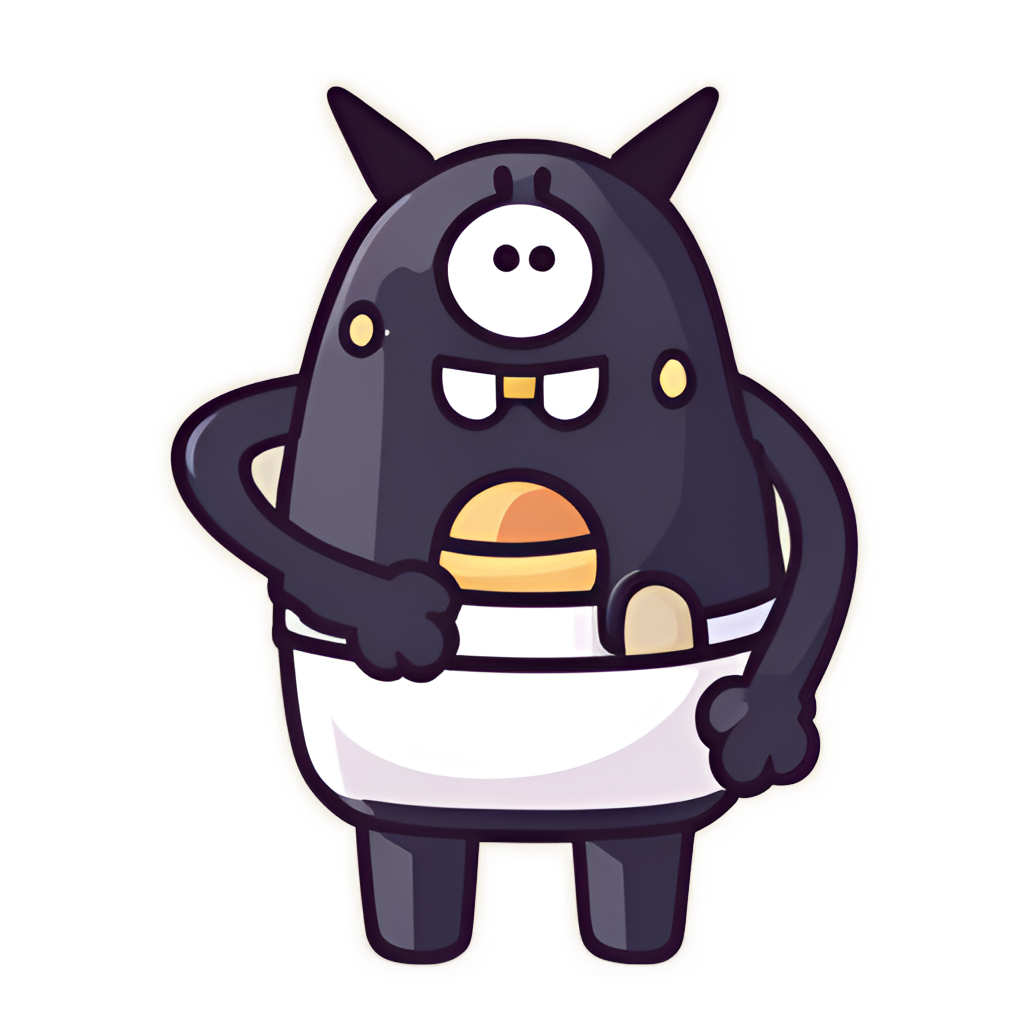

In [ ]:
foreground_alpha2

In [ ]:
filename = os.path.basename(input_url)

file_path = '/content/drive/MyDrive/스모어톡/프리렌서/배경제거/nukki_test/output_sam_vit/' + filename


plt.imsave(file_path, np.array(foreground_alpha2), format='png')